In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
from torch.utils.data import DataLoader
import torch
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv

sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
import data_vis_utils as dvu

import loadpaths_pecl
path_dict_pecl = loadpaths_pecl.loadpaths()
import shapely
from tqdm import tqdm, tqdm_notebook
import os
import pandas as pd
import ast


Font size is set to 10


In [11]:
tb_log_folder='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/models/PECL/random_search/'
stats_folder = os.path.join(tb_log_folder, 'stats')
model_folder = os.path.join(tb_log_folder, 'full_models')
assert os.path.exists(stats_folder), f'Folder {stats_folder} does not exist.'
assert os.path.exists(model_folder), f'Folder {model_folder} does not exist.'

# model_name = 'PECL-ImEn_2024-03-07-1631_vnum-54.data'
# list_model_names = dvu.get_list_timestamps_from_vnums(path_stats=stats_folder, list_vnums=[54, 55, 56])
list_model_names = dvu.get_list_timestamps_from_vnums(path_stats=stats_folder, list_vnums=[96, 97, 98])
list_model_names = [x.replace('_stats.pkl', '.data') for x in list_model_names]
filepath_train_val_split = os.path.join(path_dict_pecl['repo'], 'content/split_indices_2024-03-04-1831.pth')
assert os.path.exists(filepath_train_val_split), f'File {filepath_train_val_split} does not exist.'

ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')
train_ds, val_ds, test_ds = ds.split_into_train_val(filepath=filepath_train_val_split)

test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)


dict_models = {}
for model_name in list_model_names:
    tmp_model = pem.load_model(filename=model_name,
                               folder=model_folder
                                )
    tmp_model.eval()
    dict_models[model_name] = tmp_model
    
# tmp_model = pem.load_model(filename=model_name,
#                            folder=model_folder)
# tmp_model.eval() 


Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Loaded ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

PECL-ImEn_2024-03-07-1631_vnum-54.data'

test_top_20_acc	test_top_10_acc	test_top_5_acc	test_top_1_acc	test_bce_loss	test_mse_loss	test_mae_loss
0.853495	     0.712366	     0.633333	    0.413978	    0.227593	      0.011745	     0.058107

In [12]:
tmp_bool_use_dl = True
dict_preds = {}
dict_im_encs = {} 
if tmp_bool_use_dl:
    with torch.no_grad():
        for i_batch, batch in tqdm(enumerate(test_dl)):
            im, label = batch 
            
            for i_model, (model_name, tmp_model) in enumerate(dict_models.items()):
                im = im.to(tmp_model.device)
                im_enc = tmp_model.forward(im)
                pred = tmp_model.prediction_model(im_enc)
                
                if i_batch == 0:
                    if i_model == 0:
                        all_labels = label.clone() 
                    dict_im_encs[model_name] = im_enc.clone()
                    dict_preds[model_name] = pred.clone()
                else:
                    if i_model == 0:
                        all_labels = torch.cat([all_labels, label], dim=0)
                    dict_im_encs[model_name] = torch.cat([dict_im_encs[model_name], im_enc], dim=0)
                    dict_preds[model_name] = torch.cat([dict_preds[model_name], pred], dim=0)
            
else:
    all_labels = []
    for sample in tqdm(test_ds):
        all_labels.append(sample[1][None, :])
    all_labels = torch.cat(all_labels, dim=0)

print(all_labels.shape)
for model_name, tmp_model in dict_models.items():
    dict_im_encs[model_name] = dict_im_encs[model_name].cpu().numpy()
    dict_preds[model_name] = dict_preds[model_name].cpu().numpy()
    print(model_name)
    print(dict_im_encs[model_name].shape)
    print(dict_preds[model_name].shape)

## change to np
all_labels = all_labels.cpu().numpy()
# all_im_encs = all_im_encs.cpu().numpy()
# all_preds = all_preds.cpu().numpy()

3it [00:33, 11.00s/it]

torch.Size([186, 62])
PECL-ImEn_2024-03-08-0138_vnum-96.data
(186, 256)
(186, 62)
PECL-ImEn_2024-03-08-0154_vnum-97.data
(186, 256)
(186, 62)
PECL-ImEn_2024-03-08-0211_vnum-98.data
(186, 256)
(186, 62)


In [13]:
print(all_labels.shape)

mean_rates = train_ds.dataset.df_presence[train_ds.dataset.species_list].values.mean(0)
mean_rates_matrix = np.tile(mean_rates, (all_labels.shape[0], 1))
print(mean_rates.shape, mean_rates_matrix.shape)
mse_per_element_mr = np.power((all_labels - mean_rates_matrix), 2)
mse_per_species_mr = np.mean(mse_per_element_mr, axis=0)
mse_per_location_mr = np.mean(mse_per_element_mr, axis=1)
mse_total_mr = np.mean(mse_per_element_mr)
mean_rate_per_location = np.mean(all_labels, axis=1)
n_species_per_location = np.sum(all_labels > 0, axis=1)
# model_keys = list(dict_models.keys())
# all_preds = dict_preds[model_keys[2]]

mse_per_species_all = np.zeros((len(list_model_names), mse_per_species_mr.shape[0]))
mse_per_location_all = np.zeros((len(list_model_names), mse_per_location_mr.shape[0]))
for i_model, (model_name, all_preds) in enumerate(dict_preds.items()):
    print(model_name)

    mse_per_element = np.power((all_labels - all_preds), 2)
    mse_per_species = np.mean(mse_per_element, axis=0)
    mse_per_location = np.mean(mse_per_element, axis=1)
    mse_total = np.mean(mse_per_element)

    print(mse_per_element.shape, mse_per_species.shape, mse_per_location.shape, mse_total)

    mse_per_species_all[i_model, :] = mse_per_species
    mse_per_location_all[i_model, :] = mse_per_location
    
mse_per_species_mean = np.mean(mse_per_species_all, axis=0)
mse_per_location_mean = np.mean(mse_per_location_all, axis=0)\

test_df_presence = test_ds.dataset.df_presence.iloc[test_ds.indices]
coords_points = [shapely.geometry.Point(ast.literal_eval(loc)) for loc in test_df_presence.tuple_coords]
gdf = gpd.GeoDataFrame(test_df_presence, geometry=coords_points)
gdf['factor_mse_improvement'] = mse_per_location_mr / mse_per_location_mean


(186, 62)
(62,) (186, 62)
PECL-ImEn_2024-03-08-0138_vnum-96.data
(186, 62) (62,) (186,) 0.010796474
PECL-ImEn_2024-03-08-0154_vnum-97.data
(186, 62) (62,) (186,) 0.0110163
PECL-ImEn_2024-03-08-0211_vnum-98.data
(186, 62) (62,) (186,) 0.01089924


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


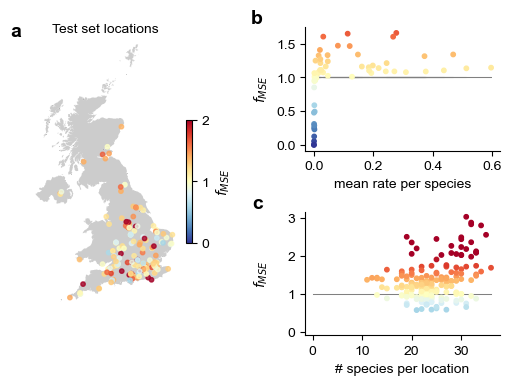

In [50]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 3))
fig, ax = plt.subplot_mosaic([['map', 'species'], ['map', 'location']], figsize=(6, 4),
                             gridspec_kw={'wspace': 0.5, 'hspace': 0.5, 'width_ratios': [1, 1.1]})

ax_map = ax['map']
ax_species = ax['species']
ax_location = ax['location']

label_mse = r"$f_{MSE}$"

path_map = '/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/GBR_adm/GBR_adm0.shp'
gdf_uk = gpd.read_file(path_map)
gdf_uk.plot(ax=ax_map, color='k', alpha=0.2)
gdf.crs = gdf_uk.crs
gdf.plot(ax=ax_map, column='factor_mse_improvement',
         cmap='RdYlBu_r', vmin=0, vmax=2, 
        legend_kwds={'label': label_mse, 'ticks': [0, 1, 2],
                    #  'tick_labels': ['0', '1', '>2'],
                     'shrink': 0.4, 'location': 'right'},
         legend=True, markersize=10,
         alpha=0.8)

ax_map.set_xlim([-8.2, 2])
ax_map.set_ylim([49, 61])
rfv.naked(ax_map)
# ax_map.set_xlabel('Longitude')
# ax_map.set_ylabel('Latitude')
ax_map.set_title('Test set locations')

ax_species.plot(mean_rates, np.ones_like(mean_rates), c='grey', zorder=-1, linewidth=0.75)
factor_species = mse_per_species_mr / mse_per_species_mean
ax_species.scatter(mean_rates, factor_species,  
                   label='model', s=10,
                   c=factor_species, cmap=cmap_loc, vmax=2, vmin=0)
ax_species.set_xlabel('mean rate per species')
ax_species.set_ylabel(label_mse)
x_lims_species = ax_species.get_xlim()
ylims_species = ax_species.get_ylim()
# ax_species.set_xlim([0, x_lims_species[1]])
# ax_species.set_ylim([0, ylims_species[1]])


ax_location.plot([0, n_species_per_location.max()], [1, 1], c='grey', zorder=-1, linewidth=0.75)
factor_loc = mse_per_location_mr / mse_per_location_mean
cmap_loc = plt.get_cmap('RdYlBu_r')
ax_location.scatter(n_species_per_location, factor_loc,  label='model', s=10, 
                    c=factor_loc, cmap=cmap_loc, vmax=2, vmin=0)
# ax_location.scatter(n_species_per_location,   label='model', s=10)
ax_location.set_xlabel('# species per location')
ax_location.set_ylabel(label_mse)
ylims_loc = ax_location.get_ylim()
ax_location.set_ylim([ylims_species[0], ylims_loc[1]])
x_lims_loc = ax_location.get_xlim()
ax_location.set_xlim([-1.5, x_lims_loc[1]])

rfv.despine(ax_species)
rfv.despine(ax_location)
rfv.add_panel_label(ax_map, label_letter='a', fontsize=14, x_offset=0.15)
rfv.add_panel_label(ax_species, label_letter='b', fontsize=14)
rfv.add_panel_label(ax_location, label_letter='c', fontsize=14)
fig.align_ylabels([ax_species, ax_location])

plt.savefig(os.path.join(path_dict_pecl['repo'], 'figures/mse_improvement_factor.pdf'), bbox_inches='tight')

In [15]:
np.sort(mean_rates[factor_species < 1])

array([2.35139202e-05, 4.80710490e-05, 9.30906108e-05, 3.98739789e-04,
       5.12103174e-04, 6.77381483e-04, 8.38663155e-04, 8.54972139e-04,
       1.21136669e-03, 1.32559669e-03, 1.38142071e-03, 1.69790073e-03,
       2.54449199e-03, 2.58098209e-03, 2.72098047e-03, 3.82465989e-03,
       3.87839306e-03, 8.08609883e-03])

In [17]:
import scipy.stats
scipy.stats.pearsonr(n_species_per_location, factor_loc)

PearsonRResult(statistic=0.34222021882064874, pvalue=1.7446866603214961e-06)

In [174]:
test_df_presence = test_ds.dataset.df_presence.iloc[test_ds.indices]
coords_points = [shapely.geometry.Point(ast.literal_eval(loc)) for loc in test_df_presence.tuple_coords]
gdf = gpd.GeoDataFrame(test_df_presence, geometry=coords_points)
gdf['factor_mse_improvement'] = mse_per_location_mr / mse_per_location


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


(49.0, 61.0)

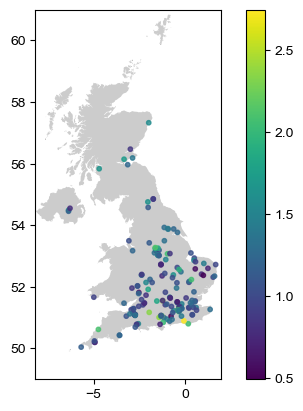

In [173]:
ax_map = plt.subplot(111)

path_map = '/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/GBR_adm/GBR_adm0.shp'
gdf_uk = gpd.read_file(path_map)
# print(gdf_uk.crs)
# gdf_uk.crs = 'epsg:27700'
# gdf_uk = gdf_uk.set_crs('epsg:27700', allow_override=True)
gdf_uk.plot(ax=ax_map, color='k', alpha=0.2)

gdf.crs = gdf_uk.crs
# gdf.crs = 'epsg:27700'

gdf.plot(ax=ax_map, column='factor_mse_improvement',
         cmap='viridis',
         # cmap='RdYlBu_r', vmin=0, vmax=2, 
         legend=True, markersize=10,
         alpha=0.8)

ax_map.set_xlim([-8.2, 2])
ax_map.set_ylim([49, 61])

In [144]:
gdf_uk.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

# Tables

In [64]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')

tmp = dvu.print_table_results_per_species(ds=ds, filepath_train_val_split='../../content/split_indices_2024-03-04-1831.pth',
                                          save_table=True)

Font size is set to 10
Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Number of samples in train set: 947
Number of samples in val set: 196
Number of samples in test set: 186


In [59]:
tmp

,species,P(presence) train [\%],P(presence) val [\%],P(presence) test [\%]
0,Melanargia galathea,10.61,12.36,14.10
1,Pieris napi,37.77,36.88,37.70
2,Aphantopus hyperantus,23.88,24.12,25.74
3,Aglais io,31.16,30.56,30.29
4,Polyommatus icarus,35.88,39.20,41.89
...,...,...,...,...
57,Melitaea cinxia,0.06,0.00,0.00
58,Carterocephalus palaemon,0.12,0.00,0.00
59,Nymphalis polychloros,0.00,0.04,0.01
60,Nymphalis antiopa,0.01,0.00,0.00


In [42]:
tmp = dvu.print_table_mlplayers_pretrained(save_table=True)
tmp = dvu.print_table_mlplayers_pretrained_lr(save_table=True)

Font size is set to 10
Loaded stats from PECL-ImEn_2024-03-04-2244_vnum-324_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2302_vnum-325_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2321_vnum-326_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2339_vnum-327_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-04-2357_vnum-328_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0016_vnum-329_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0035_vnum-330_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0053_vnum-331_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0112_vnum-332_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024

In [39]:
tmp[1]

,MLP,Pretrained,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,nan,Mean rates,67.3,58.7,1.39
1,1.0,ImageNet,68.9 $\pm$ 0.8,60.9 $\pm$ 1.0,1.33 $\pm$ 0.05
2,1.0,SeCo,69.1 $\pm$ 0.5,61.8 $\pm$ 0.9,1.34 $\pm$ 0.04
3,2.0,ImageNet,\textbf{69.7 $\pm$ 0.5},61.5 $\pm$ 0.7,1.24 $\pm$ 0.03
4,2.0,SeCo,69.5 $\pm$ 0.4,\textbf{62.4 $\pm$ 0.8},1.22 $\pm$ 0.04
5,3.0,ImageNet,69.0 $\pm$ 0.5,61.8 $\pm$ 0.7,1.24 $\pm$ 0.03
6,3.0,SeCo,69.6 $\pm$ 0.2,62.4 $\pm$ 1.0,\textbf{1.21 $\pm$ 0.04}


In [25]:
tmp = dvu.print_table_cr_32(split_use='test', save_table=True)

Loaded stats from PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1049_vnum-396_st

In [26]:
tmp[0]

pecl_knn pecl_knn_hard_labels training_method alpha_ratio_loss  \
                                                                   
0        2                 True            pred              0.0   
1        1                False   pred_and_pecl              0.1   
2        2                False   pred_and_pecl              0.1   
3        5                False   pred_and_pecl              0.1   
4        1                False   pred_and_pecl              0.3   
5        2                False   pred_and_pecl              0.3   
6        5                False   pred_and_pecl              0.3   

  batch_size_used        name_train_loss    Top-10               Top-5  \
                                              mean       sem      mean   
0              64               pred-bce  0.695699  0.001728  0.624373   
1              32  pred-bce_pecl-softmax  0.698029  0.006810  0.624014   
2              32  pred-bce_pecl-softmax  0.695878  0.005468  0.624373   
3              32  pred-bce_pecl-softmax  0.700179  0.002350  0.622939   
4              32  pred-bce_pecl-softmax  0.697133  0.006409  0.625090   
5              32  pred-bce_pecl-softmax  0.698566  0.007586  0.622581   
6              32  pred-bce_pecl-softmax  0.695878  0.005760  0.621147   

                  MSE            
        sem      mean       sem  
0  0.009901  0.012108  0.000370  
1  0.008429  0.012069  0.000341  
2  0.005868  0.012307  0.000191  
3  0.006218  0.012078  0.000305  
4  0.006462  0.012084  0.000436  
5  0.006541  0.012254  0.000382  
6  0.006341  0.012320  0.000302

In [27]:
tmp[1]

,$k$,$\alpha$,Batch,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,2,0.0,64,69.6 $\pm$ 0.2,62.4 $\pm$ 1.0,1.21 $\pm$ 0.04
1,1,0.1,32,69.8 $\pm$ 0.7,62.4 $\pm$ 0.8,\textbf{1.21 $\pm$ 0.03}
2,2,0.1,32,69.6 $\pm$ 0.5,62.4 $\pm$ 0.6,1.23 $\pm$ 0.02
3,5,0.1,32,\textbf{70.0 $\pm$ 0.2},62.3 $\pm$ 0.6,1.21 $\pm$ 0.03
4,1,0.3,32,69.7 $\pm$ 0.6,\textbf{62.5 $\pm$ 0.6},1.21 $\pm$ 0.04
5,2,0.3,32,69.9 $\pm$ 0.8,62.3 $\pm$ 0.7,1.23 $\pm$ 0.04
6,5,0.3,32,69.6 $\pm$ 0.6,62.1 $\pm$ 0.6,1.23 $\pm$ 0.03


In [28]:
list_vnums = list(np.arange(386, 405))
list_vnums.remove(389)  # broken run
list_vnums = list_vnums + [335, 338, 341]  # alpha=0 runs
tmp_df, tmp_details = dvu.create_df_list_timestamps(list_ts=dvu.get_list_timestamps_from_vnums(
    list_vnums=list_vnums), split_use='test')

Loaded stats from PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1049_vnum-396_st

In [35]:
tmp_df[tmp_df.columns[13:-3]]

,pecl_knn,pecl_knn_hard_labels,training_method,alpha_ratio_loss,normalise_embedding,use_mps,use_lr_scheduler,seed_used,batch_size_used,p_dropout,verbose,time_created,name_train_loss,n_epochs_converged,test_top_20_acc,test_top_10_acc,test_top_5_acc,test_top_1_acc
0,1,False,pred_and_pecl,0.1,l2,True,False,42,32,0,1,2024-03-05-2322:14,pred-bce_pecl-softmax,51,0.853226,0.704839,0.640860,0.424731
1,1,False,pred_and_pecl,0.3,l2,True,False,42,32,0,1,2024-03-05-2337:42,pred-bce_pecl-softmax,51,0.850806,0.704839,0.637634,0.446237
2,1,False,pred_and_pecl,0.1,l2,True,False,17,32,0,1,2024-03-05-2353:10,pred-bce_pecl-softmax,51,0.855376,0.684409,0.616129,0.333333
3,1,False,pred_and_pecl,0.3,l2,True,False,17,32,0,1,2024-03-06-0859:16,pred-bce_pecl-softmax,51,0.855914,0.684409,0.621505,0.349462
4,1,False,pred_and_pecl,0.1,l2,True,False,86,32,0,1,2024-03-06-0915:17,pred-bce_pecl-softmax,51,0.848118,0.704839,0.615054,0.435484
5,1,False,pred_and_pecl,0.3,l2,True,False,86,32,0,1,2024-03-06-0930:54,pred-bce_pecl-softmax,51,0.844892,0.702150,0.616129,0.413978
6,2,False,pred_and_pecl,0.1,l2,True,False,42,32,0,1,2024-03-06-0946:28,pred-bce_pecl-softmax,51,0.851344,0.701613,0.632258,0.365591
7,2,False,pred_and_pecl,0.3,l2,True,False,42,32,0,1,2024-03-06-1002:21,pred-bce_pecl-softmax,51,0.853226,0.712903,0.633333,0.435484
8,2,False,pred_and_pecl,0.1,l2,True,False,17,32,0,1,2024-03-06-1017:55,pred-bce_pecl-softmax,51,0.850538,0.684946,0.627957,0.360215
9,2,False,pred_and_pecl,0.3,l2,True,False,17,32,0,1,2024-03-06-1033:42,pred-bce_pecl-softmax,51,0.851882,0.687097,0.623656,0.317204


Loaded stats from PECL-ImEn_2024-03-05-0207_vnum-335_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0303_vnum-338_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0358_vnum-341_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-08-0138_vnum-96_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats
Loaded stats from PECL-ImEn_2024-03-08-0154_vnum-97_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats
Loaded stats from PECL-ImEn_2024-03-08-0211_vnum-98_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean rates top_5: 0.5870967507362366


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Mean rates top_10: 0.6731182336807251


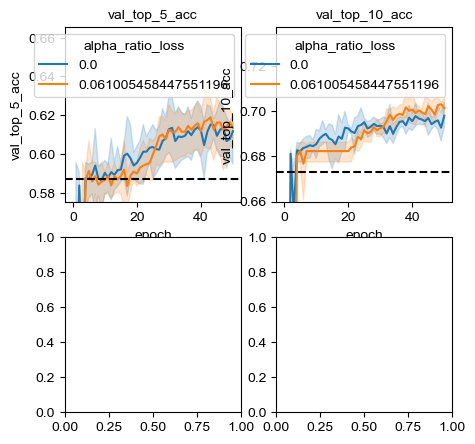

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

# list_vnums_1 = [399, 401, 403] + [335, 338, 341]  # alpha=0 runs
list_vnums_no_cr = [335, 338, 341]  # alpha=0 runs
list_ts_no_cr = dvu.get_list_timestamps_from_vnums(list_vnums=list_vnums_no_cr)

tb_log_folder='/Users/t.vanderplas/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/models/PECL/random_search/'
stats_folder = os.path.join(tb_log_folder, 'stats')
model_folder = os.path.join(tb_log_folder, 'full_models')

list_ts_cr = dvu.get_list_timestamps_from_vnums(path_stats=stats_folder, list_vnums=[96, 97, 98])
# list_ts_cr = [x.replace('_stats.pkl', '.data') for x in list_ts_cr]
dict_stats = {**dvu.load_list_timestamps(list_ts_no_cr), 
              **dvu.load_list_timestamps(list_ts_cr, folder=stats_folder)}
list_ts = list(dict_stats.keys())
for i_plot, metric in enumerate(['val_top_5_acc', 'val_top_10_acc']):
    tmp = dvu.plot_val_timeseries(list_ts=list_ts, dict_stats=dict_stats,
                              metric_show=metric, ax=ax[0, i_plot], hue_hparam='alpha_ratio_loss')
    ax[0, i_plot].set_title(metric)
    # tmp = dvu.plot_val_timeseries(list_ts=dvu.get_list_timestamps_from_vnums(np.arange(380, 386)),
    #                           metric_show=metric, ax=ax[1, i_plot])
    # ax[1, i_plot].set_title(metric)

In [32]:
# tmp = dvu.print_table_test(split_use='test', save_table=False, list_vnums=np.arange(405, 411))
tmp = dvu.print_table_model_changes(save_table=True)

Loaded stats from PECL-ImEn_2024-03-06-1546_vnum-405_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1606_vnum-406_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1625_vnum-407_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0207_vnum-335_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0303_vnum-338_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-0358_vnum-341_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1136_vnum-399_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1207_vnum-401_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1328_vnum-403_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Hyperparameter freeze_resnet has 2 unique values
Hyperp

In [31]:
tmp[1]

,Freeze Res,$\alpha$,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,NaN,nan,67.3,58.7,1.39
1,False,0.0,68.2 $\pm$ 0.2,61.8 $\pm$ 0.8,1.32 $\pm$ 0.03
2,True,0.0,69.6 $\pm$ 0.2,\textbf{62.4 $\pm$ 1.0},1.21 $\pm$ 0.04
3,True,0.1,\textbf{70.0 $\pm$ 0.2},62.3 $\pm$ 0.6,\textbf{1.21 $\pm$ 0.03}


In [55]:
tmp = dvu.print_table_cr_32(save_table=True)

Loaded stats from PECL-ImEn_2024-03-05-2337_vnum-386_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-05-2353_vnum-387_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0008_vnum-388_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0915_vnum-390_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0930_vnum-391_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-0946_vnum-392_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1002_vnum-393_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1017_vnum-394_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1033_vnum-395_stats.pkl at /Users/t.vanderplas/models/PECL/stats/
Loaded stats from PECL-ImEn_2024-03-06-1049_vnum-396_st

In [54]:
tmp[1]

,$k$,$\alpha$,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,2,0.0,69.6 $\pm$ 0.2,62.4 $\pm$ 1.0,1.21 $\pm$ 0.04
1,1,0.1,69.8 $\pm$ 0.7,62.4 $\pm$ 0.8,\textbf{1.21 $\pm$ 0.03}
2,2,0.1,69.6 $\pm$ 0.5,62.4 $\pm$ 0.6,1.23 $\pm$ 0.02
3,5,0.1,\textbf{70.0 $\pm$ 0.2},62.3 $\pm$ 0.6,1.21 $\pm$ 0.03
4,1,0.3,69.7 $\pm$ 0.6,\textbf{62.5 $\pm$ 0.6},1.21 $\pm$ 0.04
5,2,0.3,69.9 $\pm$ 0.8,62.3 $\pm$ 0.7,1.23 $\pm$ 0.04
6,5,0.3,69.6 $\pm$ 0.6,62.1 $\pm$ 0.6,1.23 $\pm$ 0.03


In [9]:
tmp_ = dvu.print_table_randomsearch(save_table=True)

Font size is set to 10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 72, 73, 74, 75, 76, 77, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]
Loaded stats from PECL-ImEn_2024-03-06-1853_vnum-0_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats/
Loaded stats from PECL-ImEn_2024-03-06-1907_vnum-1_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats/
Loaded stats from PECL-ImEn_2024-03-06-1921_vnum-2_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats/
Loaded stats from PECL-ImEn_2024-03-07-0033_vnum-3_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats/
Loaded stats from PECL-ImEn_2024-03-07-0050_vnum-4_stats.pkl at /Users/t.vanderplas/models/PECL/random_search/stats/
Loaded stats from PECL-ImEn_20

In [7]:
# tmp[0]['vnum'] = tmp[0]['timestamp'].apply(lambda x: int(x.split('_')[2].lstrip('vnum-')))
# tmp[0][['timestamp', 'vnum', 'seed_used', 'alpha_ratio_loss', 'temperature', 'pecl_knn', 'lr', 'batch_size_used']]

In [8]:
tmp[1]

,Rank,LR,$k$,$\alpha$,Batch,temperature,Top-10 [\%],Top-5 [\%],MSE [1e-02]
0,1,0.00029,2,0.061,64,0.72,\textbf{70.4 $\pm$ 0.2},\textbf{63.0 $\pm$ 0.9},\textbf{1.20 $\pm$ 0.03}
1,2,0.00066,2,0.792,16,0.64,69.7 $\pm$ 0.6,62.9 $\pm$ 1.0,1.20 $\pm$ 0.04
2,3,0.00049,1,0.061,64,0.48,70.1 $\pm$ 0.3,62.8 $\pm$ 1.0,1.21 $\pm$ 0.03
3,4,0.00015,5,0.414,16,0.74,69.9 $\pm$ 0.8,62.0 $\pm$ 0.7,1.22 $\pm$ 0.04
4,5,0.00009,2,0.249,8,0.57,69.8 $\pm$ 0.5,62.7 $\pm$ 1.0,1.22 $\pm$ 0.03
5,6,0.00127,8,0.226,32,0.37,69.8 $\pm$ 0.4,62.3 $\pm$ 0.5,1.22 $\pm$ 0.03
6,7,0.00015,9,0.234,64,0.74,69.2 $\pm$ 0.2,62.3 $\pm$ 0.8,1.22 $\pm$ 0.03
7,8,0.00016,4,0.064,64,0.57,69.5 $\pm$ 0.3,62.3 $\pm$ 0.9,1.22 $\pm$ 0.04
8,9,0.00172,10,0.561,32,0.60,69.3 $\pm$ 0.2,61.4 $\pm$ 0.6,1.22 $\pm$ 0.03
9,10,0.00015,8,0.066,64,0.50,69.4 $\pm$ 0.1,62.2 $\pm$ 0.8,1.23 $\pm$ 0.04


In [10]:
tmp_[0][np.logical_and(tmp_[0]['pecl_knn'] == 2, tmp_[0]['batch_size_used'] == 64)]

,timestamp,n_species,n_enc_channels,n_bands,n_layers_mlp_resnet,n_layers_mlp_pred,pretrained_resnet,freeze_resnet,optimizer_name,resnet_version,...,time_created,name_train_loss,n_epochs_converged,test_top_20_acc,test_top_10_acc,test_top_5_acc,test_top_1_acc,test_bce_loss,test_mse_loss,test_mae_loss
30,PECL-ImEn_2024-03-07-0548_vnum-30_stats.pkl,62,256,4,1,3,seco,True,Adam,18,...,2024-03-07-0532:04,pred-bce_pecl-softmax,51,0.843280,0.681720,0.608602,0.467742,0.238193,0.013202,0.069416
31,PECL-ImEn_2024-03-07-0605_vnum-31_stats.pkl,62,256,4,1,3,seco,True,Adam,18,...,2024-03-07-0548:43,pred-bce_pecl-softmax,51,0.850269,0.672043,0.604301,0.397849,0.239396,0.013519,0.071999
32,PECL-ImEn_2024-03-07-0622_vnum-32_stats.pkl,62,256,4,1,3,seco,True,Adam,18,...,2024-03-07-0605:23,pred-bce_pecl-softmax,51,0.835484,0.673656,0.573118,0.473118,0.242837,0.014943,0.073007
75,PECL-ImEn_2024-03-08-0138_vnum-96_stats.pkl,62,256,4,1,3,seco,True,Adam,18,...,2024-03-08-0121:31,pred-bce_pecl-softmax,51,0.852688,0.706989,0.645161,0.376344,0.228702,0.011960,0.057959
76,PECL-ImEn_2024-03-08-0154_vnum-97_stats.pkl,62,256,4,1,3,seco,True,Adam,18,...,2024-03-08-0138:08,pred-bce_pecl-softmax,51,0.855376,0.699462,0.632258,0.354839,0.226005,0.011584,0.057989
77,PECL-ImEn_2024-03-08-0211_vnum-98_stats.pkl,62,256,4,1,3,seco,True,Adam,18,...,2024-03-08-0154:42,pred-bce_pecl-softmax,51,0.848387,0.704301,0.613979,0.408602,0.229477,0.012474,0.059739


In [18]:
tmp_[1][1]

['n_species',
 'n_enc_channels',
 'n_bands',
 'n_layers_mlp_resnet',
 'n_layers_mlp_pred',
 'pretrained_resnet',
 'freeze_resnet',
 'optimizer_name',
 'resnet_version',
 'pecl_distance_metric',
 'pred_train_loss',
 'lr',
 'pecl_knn',
 'pecl_knn_hard_labels',
 'training_method',
 'alpha_ratio_loss',
 'normalise_embedding',
 'use_mps',
 'use_lr_scheduler',
 'seed_used',
 'batch_size_used',
 'p_dropout',
 'temperature',
 'verbose',
 'time_created',
 'name_train_loss',
 'n_epochs_converged']